In [22]:
# Library Imports
# Data storing Imports
import numpy as np
import pandas as pd

# Clustering imports
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import hdbscan
import skfuzzy as fuzz

# Cluster performance comparison metric imports
from sklearn.metrics import silhouette_score


# Distance Calculation Imports
import gower

# MDS Import
from sklearn.manifold import MDS

# Function imports from other files
import data_preparation as dp

# Plotting Imports
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# Reading in data for testing
data = pd.read_csv('test_data/2020-05-01.csv')
data = data.drop_duplicates(subset=['equipRef','groupRef','navName','siteRef','typeRef','unit'])
print(data.shape)
print(data['unit'].unique())
data.head()

(4452, 8)
['ppm' '°C' 'omit' 'Pa' '%' 'ft/min' 'L/s' '_' 'L' 'A' 'kPa' 'psi' '°F'
 'kW' '%RH' 'min' 'W' 'V' 'kWh' 'm³' 'Hz' 'rpm']


,datetime,equipRef,groupRef,navName,siteRef,typeRef,unit,value
0,2020-05-01 00:00:01+00:00,EF-B02,Pharmacy Air Systems,EF_B02_RLD_CH1_3,Pharmacy,EF_B02_RLD_CH1_3,ppm,2.107125
1,2020-05-01 00:00:01+00:00,Heating Plant SBLR-1,Pharmacy Hydronic Systems,SB1_2_FGAS_INLET_T,Pharmacy,SB1_2_FGAS_INLET_T,°C,274.787537
2,2020-05-01 00:00:01+00:00,Rm 2340 VAV-2S008,Pharmacy Floor 2,Zone Temp,Pharmacy,VAV_2S008_RT_AV,°C,24.574572
3,2020-05-01 00:00:01+00:00,Rm B612 FC-B06,Pharmacy Floor 0,Discharge Fan Run Cmd,Pharmacy,FCU_B06_C,omit,True
4,2020-05-01 00:00:02+00:00,AHU-06,Pharmacy Air Systems,AHU6_SPACE_DP(MUX),Pharmacy,AHU6_SPACE_DP(MUX),Pa,7.981429


# Scaling values and encoding values and units
The function for scaling and encoding values is different from the one for scaling units so the resulting dataframes need to be merged. It has been kept this way as I'm not sure what will need to be done to incorporate the features from the SkySpark metadata and it will be more efficient to write the function that combines the three dataframes together at once rather than one at a time. 

In [3]:
# Encoding and scaling the values and encoding the units, combining units and values the dataframes and displaying the resulting dataframes
df_vals = dp.encode_and_scale_values(data)
df_units = dp.encode_units(data)
df = df_vals.merge(df_units.drop('value', axis=1), on=['datetime','equipRef','groupRef','navName','siteRef','typeRef', 'unit'])
df.head()

,datetime,equipRef,groupRef,navName,siteRef,typeRef,unit,value,cv_0,cv_1,...,unit_12,unit_13,unit_14,unit_15,unit_16,unit_17,unit_18,unit_19,unit_20,unit_21
0,2020-05-01 00:00:01+00:00,EF-B02,Pharmacy Air Systems,EF_B02_RLD_CH1_3,Pharmacy,EF_B02_RLD_CH1_3,ppm,2.107125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-05-01 00:00:01+00:00,Heating Plant SBLR-1,Pharmacy Hydronic Systems,SB1_2_FGAS_INLET_T,Pharmacy,SB1_2_FGAS_INLET_T,°C,274.787537,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-05-01 00:00:01+00:00,Rm 2340 VAV-2S008,Pharmacy Floor 2,Zone Temp,Pharmacy,VAV_2S008_RT_AV,°C,24.574572,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-05-01 00:00:01+00:00,Rm B612 FC-B06,Pharmacy Floor 0,Discharge Fan Run Cmd,Pharmacy,FCU_B06_C,omit,True,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-05-01 00:00:02+00:00,AHU-06,Pharmacy Air Systems,AHU6_SPACE_DP(MUX),Pharmacy,AHU6_SPACE_DP(MUX),Pa,7.981429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Calculating the Gower's distances
NOTE: Categorical observations are currently identified with 0 when none of the categories apply, I don't think this should be a problem since we can tell the gower_matrix function which columns are categorical, so it should know that 0 indicates the lack of a value rather than the presence of something else.

In [106]:
# Generating list of Booleans for identifying which columns are categorical and which aren't (pass in a list of columns that are continuous and the number predictor variables)
def make_categorical_list(cont_idxs, num_predictors):
    if type(cont_idxs)==int: cont_idxs = [cont_idxs]
    is_Cat = []
    for i in range(num_predictors):
        if i in cont_idxs:
            is_Cat.append(False)
        else:
            is_Cat.append(True)
    return is_Cat

In [107]:
# Function to simplify calculating Gower's distance (pass in the dataframe and the indexes of the columns that are categorical)
def calc_gowers(df, continuous_columns):
    catList = make_categorical_list(continuous_columns, len(df.columns)-8)
    data_np = df.iloc[:,8:].to_numpy()
    gow_dists = gower.gower_matrix(data_np, cat_features=catList)
    return gow_dists

In [108]:
# Testing the make_categorical_list() and calc_gowers() functions
gow_dists = calc_gowers(df, [10])
gow_dists

array([[0.0000000e+00, 6.0606256e-02, 6.0606077e-02, ..., 6.0606077e-02,
        6.0606077e-02, 6.0606077e-02],
       [6.0606256e-02, 0.0000000e+00, 1.8048814e-07, ..., 1.8170053e-07,
        1.8124335e-07, 1.7965388e-07],
       [6.0606077e-02, 1.8048814e-07, 0.0000000e+00, ..., 1.2123854e-09,
        7.5520851e-10, 8.3426427e-10],
       ...,
       [6.0606077e-02, 1.8170053e-07, 1.2123854e-09, ..., 0.0000000e+00,
        4.5717685e-10, 2.0466497e-09],
       [6.0606077e-02, 1.8124335e-07, 7.5520851e-10, ..., 4.5717685e-10,
        0.0000000e+00, 1.5894728e-09],
       [6.0606077e-02, 1.7965388e-07, 8.3426427e-10, ..., 2.0466497e-09,
        1.5894728e-09, 0.0000000e+00]], dtype=float32)

# Multidimensional Scaling
Multidimensional Scaling (MDS) allows us to scale the Gower's distance data into a "coordinate system" which allows us to pass in "coordinates" into the clustering methods that don't accept relative distances. It will also allow us to plot our clusters since we can reduce dimensionality to 2-D or 3-D.

In [18]:
# Function to make MDS easier
def multidim_scale(dist_mat, num_dim=2):
    scaler = MDS(n_components=num_dim, dissimilarity='precomputed')
    scaled_data = scaler.fit_transform(dist_mat)
    return scaled_data

In [ ]:
# Scale Data to a 2-dimensional predictor space
data_2d = multidim_scale(gow_dists, num_dim=2)
print(data_2d.shape)
# Make Data into a Dataframe
data_2d_df = pd.DataFrame(data=data_2d, columns = ['x','y'])
data_2d_df

In [19]:
# Scale Data to a 3-dimensional predictor space
data_3d = multidim_scale(gow_dists, num_dim=3)
print(data_3d.shape)
# Make Data into a Dataframe
data_3d_df = pd.DataFrame(data=data_3d, columns = ['x','y','z'])
data_3d_df

(4452, 3)


,x,y,z
0,0.031128,-0.026509,-0.022413
1,-0.018406,-0.018887,-0.017202
2,-0.018406,-0.018887,-0.017202
3,-0.034412,0.066762,-0.003518
4,0.014177,0.016356,-0.036958
...,...,...,...
4447,-0.018406,-0.018887,-0.017202
4448,-0.018406,-0.018887,-0.017202
4449,-0.018406,-0.018887,-0.017202
4450,-0.018406,-0.018887,-0.017202


# Clustering Function
This function is intended for quick testing of various different clustering methods, some minimal "optimization" has been done on some of the clustering methods to make it so that they will work with the data provided. The items that have been "optimized" (for lack of a better word) are listed below:
* Agglomerative Clustering (agglom): `linkage = 'complete'`
* DBSCAN (dbscan): `eps=0.06`
* HDBSCAN (hdbscan): `cluster_selection_epsilon=0.06`
* Gausian Mixture Models (gmm): `covariance_type='spherical',n_init=100`
* Variational Bayesian estimation of a Gaussian mixture (vbgm): `covariance_type='spherical',n_init=100`

The inputs for the function are the following:
* `df`: The dataframe of values, can be raw data (input as dataframe), a matrix of Gower's distances (must pass in `input_type='gowers'`, and input must be a numpy array), or data that has already been scaled with MDS (must pass in `input_type='mds'`, and input must be a numpy array)
* `clust_type`: The type of clustering to be completed, the options are shown below, along with whether or not the model requires a num_clusts input:
|clust_type|Model|Requires num_clusts|Notes|
|:---:|:---:|:---:|:---:|
|kmeans|K-Means|True| |
|agglom|Agglomerative/Hierarchical|True| |
|dbscan|DBSCAN|False|
|hdbscan|HDBSCAN|False|
|gmm|Gausian Mixture Models|True|
|vbgm|Variational Bayesian Gaussian Mixture Models|True|
|meanshift|Mean Shift|True|
|fuzzy|Fuzzy C-Means|False|

* `num_clusts`: The number of clusters to be used (only required for some models, see `clust_type` for list of models that require `num_clusts` to be defined) NOTE: Default is `None`
* `continuous_columns`: A list of the indexes of any continuous columns, required for calculating Gower's distance required for all model types (not required if `input_type='gowers'` or `input_type='mds'` as the Gower's distance would have previously been calculated and should have incorporated this already) NOTE: Default is `None`
* `input_type`: Allows the user the option to pass in the raw data (`input_type='original'`) and have the Gower's distance (and MDS if applicable) calculated by the clustering function, or if they want to pre-calculate the Gower's (`input_type='gowers'`) distance or MDS (`input_type='mds'`). The `gowers` and `mds` input types allow for more efficient clustering if running the function multiple times as it only requires the Gower's Distance and MDS to be calculated once as opposed to every time the function is run. NOTE: Default is `input_type='original'`

In [122]:
# Function to quickly run various different clustering methods, look at the portion of the if statement to see what values each model type needs in order to run
## Available model types are: kmeans, agglom (agglomerative or hierarchical), dbscan, hdbscan, gmm (gausian mixture model), 
##                            vbgm (variational bayesian gaussian mixture model), meanshift, and fuzzy (fuzzy c-means)
def cluster(df, clust_type, num_clusts = None, continuous_columns = None, input_type='original'):
    needs_mds = ['kmeans', 'gmm', 'vbgm', 'meanshift', 'fuzzy'] # List of models that don't accept distance measures as input
    # Determines how to address the input (calculate gower's distance, store, or use as is) based on the user defined input type
    ## Allows the user to pass in either data on the original scale, as gowers distance or after performing MDS 
    ## Allows for calculating Gowers distance and MDS once before calling this function and passing it in rather than recalculating every time
    if input_type == 'original':
        fit_data = calc_gowers(df, continuous_columns)
    elif input_type == 'gowers':
        fit_data = df
    elif input_type == 'mds':
        fit_data = df
        needs_mds = []
   # Performs MDS on the Gower's distances (if needed) on the model types that require coordinate values as inputs
   # (this process allows for clustering mixed continuous and categorical within the same predictor space)     
    if clust_type in needs_mds:
        fit_data = multidim_scale(fit_data, num_dim=3) # len(df.iloc[0,:])-8 can be used to make num_dim=# of predictor variables (slight silhouette score improvement)
    # Runs the user defined clustering method
    if clust_type == 'kmeans':
        # Needs df, clust_type, num_clusts, continuous_columns
        #fit_data = df.iloc[:,8:].to_numpy()
        model = KMeans(n_clusters=num_clusts).fit(fit_data)
        preds = model.labels_
    elif clust_type == 'agglom':
        if input_type != 'gowers':
            print("Only capable of accepting Gower's Distance input at the moment") # TODO: Need to make it so that this works (broke it when adding in all the other types of clustering)
        # Needs df, clust_type, num_clusts, continuous_columns
        model = AgglomerativeClustering(affinity='precomputed', linkage = 'complete', n_clusters=num_clusts).fit(fit_data)
        preds = model.labels_
    elif clust_type == 'dbscan':
        # Needs df, clust_type, continuous_columns
        model = DBSCAN(eps=0.06, min_samples=2, metric='precomputed').fit(gow_dists)
        preds = model.labels_
    elif clust_type == 'hdbscan':
        # Needs df, clust_type, continuous_columns
        model = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_epsilon=0.06).fit(gow_dists.astype('double'))
        preds = model.labels_
    elif clust_type == 'gmm':
        # Needs df, clust_type, num_clusts, continuous_columns
        model = GaussianMixture(n_components=num_clusts, covariance_type='spherical',n_init=100).fit(fit_data)
        preds = model.predict(fit_data)
    elif clust_type == 'vbgm':
        # Needs df, clust_type, num_clusts, continuous_columns
        model = BayesianGaussianMixture(n_components=num_clusts, covariance_type='spherical',n_init=100).fit(fit_data)
        preds = model.predict(fit_data)
    elif clust_type == 'meanshift':
        # Needs df, clust_type, continuous_columns
        model = MeanShift(cluster_all=False).fit(fit_data) # cluster_all=False means that items that don't belong to a cluster or not included in any cluster (assigned to -1)
        preds = model.predict(fit_data)
    elif clust_type == 'fuzzy':
        # Needs df, clust_type, num_clusts, continuous_columns
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(np.transpose(fit_data), num_clusts, 4, error=0.005, maxiter=1000, init=None)
        preds = np.argmax(u, axis=0)
    else:
        print("Specified model type not available yet")
    try:
        # Silhouette Score appears to be the prefered cluster comparison metric used with sklearn from what I have read (1 is good, -1 is bad)
        print("Silhouette Score for {} clustering: {}".format(clust_type, silhouette_score(fit_data, preds)))
        return preds
    except:
        print('Unable to calculate silhouette score for the given model')

In [129]:
# Testing the clustering function above
test = cluster(data_3d, 'fuzzy', num_clusts = 16, continuous_columns = 10, input_type = "mds")
test_Clusts = pd.DataFrame(test, columns=["cluster"])
test_Clusts['cluster'].value_counts().sort_index()

Silhouette Score for fuzzy clustering: 0.9355881414800736


0      135
1       35
2      572
3      164
4     1340
5      164
6       82
7      341
8       97
9      239
10     138
11     190
12     234
13      66
14      45
15     610
Name: cluster, dtype: int64

***
# Testing
The rest of the code below was for testing the various types of clustering and MDS, it also has plots showing clustering results with MDS incorporated.

# K-means Clustering
Note: K-means Clustering doesn't use Gower's distance

In [9]:
# Fitting the data with k-means clustering (doesn't use Gower's distance)
data_np = df.iloc[:,8:].to_numpy()
clusterVals = data_np
kmeans = KMeans(n_clusters=16).fit(clusterVals)
print(silhouette_score(clusterVals, kmeans.labels_))
# Summarising how many observations belong to each cluster
kClusts = pd.DataFrame(kmeans.labels_, columns=["cluster"])
kClusts['cluster'].value_counts().sort_index()

0.9739217254529019


0      120
1     1340
2      610
3      572
4      239
5      107
6      232
7      136
8      171
9      329
10     155
11     135
12      90
13      98
14      60
15      58
Name: cluster, dtype: int64

# Agglomerative Clustering
Agglomerative Clustering is the same thing as hierarchical clustering
### Testing Various Linkages and number of clusters

In [10]:
# Fitting the data with Agglomerative clustering
linkage_options = ['single', 'average', 'complete']
max_clust = 25
silhouette_df = pd.DataFrame(columns=linkage_options, index=[i for i in range(2,max_clust+1)])
silhouettes = []
for link in linkage_options:
    for n_clust in range(2,max_clust+1):
        agglom = AgglomerativeClustering(affinity='precomputed', linkage = link, n_clusters=n_clust).fit(gow_dists)
        silhouette_df.loc[n_clust,link] = silhouette_score(gow_dists, agglom.labels_)

In [11]:
silhouette_df

,single,average,complete
2,-0.223586,0.504499,0.504499
3,-0.201662,0.113433,0.113433
4,-0.200067,0.0737207,0.129579
5,-0.149165,0.124762,0.131486
6,-0.101714,0.158101,0.158101
7,-0.0691655,0.131834,0.131834
8,-0.0688487,0.191641,0.317555
9,-0.0332206,0.383975,0.340748
10,-0.0113042,0.377789,0.429931
11,-0.00146301,0.378016,0.424929


In [12]:
#Identifying the top performing configuration from the above tests
cur_max = 'none'
cur_max_val = -2 # Worst case scenario is -1
for link in linkage_options:
    check_max = max(silhouette_df[link])
    if check_max >= cur_max_val:
        cur_max = link
        cur_max_val = check_max
max_idx = silhouette_df[cur_max].astype(float).idxmax()
print("Linkage for max silhouette score: "+cur_max+"\nNumber of clusters for max silhouette score: "+str(max_idx)+"\nMax silhouette score is: "+str(cur_max_val))

Linkage for max silhouette score: complete
Number of clusters for max silhouette score: 24
Max silhouette score is: 0.9880196


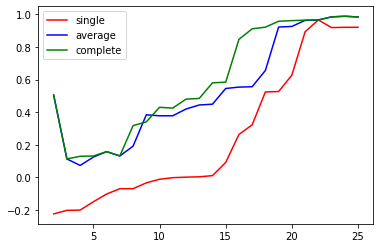

In [13]:
# Plotting silhouette scores from above
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

cols = ['red','blue','green']
for i in range(0,3):
    plt.plot(silhouette_df[linkage_options[i]], color=cols[i])
plt.legend(linkage_options)
plt.show()

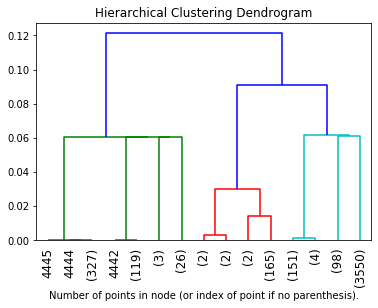

In [14]:
# Plotting Dendrogram
### NOTE: This code was copy pasted from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html for testing purposes
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity='precomputed', distance_threshold=0, n_clusters=None, linkage = 'complete')

model = model.fit(gow_dists)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=90)
plt.show()

### Fitting the best configuraiton from the for loop Grid Seach

In [15]:
# Fitting best configuration from the for loop Grid Seach
agglom = AgglomerativeClustering(affinity='precomputed', linkage = cur_max, n_clusters=max_idx).fit(gow_dists)
# Printing the Silhouette_score for the best configuration from the for loop Grid Seach
print(silhouette_score(gow_dists, agglom.labels_))
# Summarising how many observations belong to each cluster
aggClusts = pd.DataFrame(agglom.labels_, columns=["cluster"])
aggClusts['cluster'].value_counts().sort_index()

0.9880196


0       29
1      155
2      171
3      572
4       98
5       90
6       25
7     1340
8       58
9      239
10       5
11     136
12       7
13     232
14       8
15       6
16     135
17      18
18     610
19      60
20       5
21       4
22     329
23     120
Name: cluster, dtype: int64

### Fitting the best configuraiton from the for Dendrogram
From the dendrogram shown above it looks like there should be 8 clusters

In [16]:
# Fitting best configuration from the dendrogram
agglom = AgglomerativeClustering(affinity='precomputed', linkage = 'complete', n_clusters=8).fit(gow_dists)
# Printing the Silhouette_score for the best configuration from the dendrogram
print(silhouette_score(gow_dists, agglom.labels_))
# Summarising how many observations belong to each cluster
aggClusts = pd.DataFrame(agglom.labels_, columns=["cluster"])
aggClusts['cluster'].value_counts().sort_index()

0.3175549


0    2863
1     478
2     171
3     155
4      98
5      90
6      25
7     572
Name: cluster, dtype: int64

# Clustering with DBSCAN from sklearn

In [17]:
# Fitting the data with DBSCAN clustering
db_clust = DBSCAN(eps=0.06, min_samples=2, metric='precomputed').fit(gow_dists)
# Printing the cluster labels for each cluster
print(db_clust.labels_)
print(type(db_clust.labels_))
print(silhouette_score(gow_dists, db_clust.labels_))
clusts = pd.DataFrame(db_clust.labels_, columns=["cluster"])
clusts['cluster'].value_counts().sort_index()

[0 1 1 ... 1 1 1]
<class 'numpy.ndarray'>
0.96521753


0      136
1     1340
2      478
3      239
4      610
5        5
6      572
7      155
8       25
9      232
10      18
11       5
12       8
13      98
14      58
15       4
16      90
17     135
18     171
19       6
20      60
21       7
Name: cluster, dtype: int64

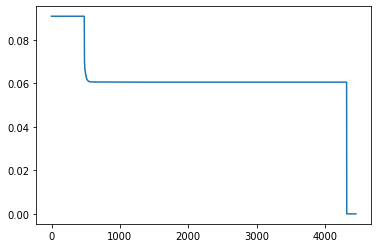

In [18]:
# k-distance plot for determining epsilon (looks like a value around 0.06 is appropriate here) (used for both DBSCAN and HDBSCAN)
from matplotlib import pyplot as plt
sorted_vals = gow_dists[0]
sorted_vals = sorted_vals[np.argsort(-gow_dists[0])]
plt.plot(sorted_vals)

# Clustering with HDBSCAN from hdbscan

In [19]:
hdb = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_epsilon=0.06).fit(gow_dists.astype('double'))
#hdbClusts = hdb
print(hdb.labels_)
print(silhouette_score(gow_dists, hdb.labels_))
hdbClusts = pd.DataFrame(hdb.labels_, columns=["cluster"])
hdbClusts['cluster'].value_counts().sort_index()

[11 13 13 ... 13 13 13]
0.91493356


-1        7
 0       59
 1       25
 2      135
 3      102
 4       90
 5      171
 6        9
 7        6
 8        9
 9       60
 10       7
 11     136
 12     610
 13    1340
 14      18
 15     239
 16     573
 17     232
 18     155
 19     469
Name: cluster, dtype: int64

# Multidimensional Scaling
Not sure if this will be of use but wanted to test since many of the clustering methods don't accept distances as inputs (requires the dataframe of values). MDS will allow us to scale the gower's distance data into a coordinate system. It will also allow us to plot our clusters since we can reduce dimensionality.

In [12]:
def multidim_scale(dist_mat, num_dim=2):
    scaler = MDS(n_components=num_dim, dissimilarity='precomputed')
    scaled_data = scaler.fit_transform(dist_mat)
    return scaled_data

In [21]:
# Scale the data down to 2 degrees
#scaler = MDS(dissimilarity='precomputed')
#data_2d = scaler.fit_transform(gow_dists)
data_2d = multidim_scale(gow_dists, num_dim=2)
data_2d.shape

(4452, 2)

In [22]:
# Make Data into a Dataframe
data_2d_df = pd.DataFrame(data=data_2d, columns = ['x','y'])
data_2d_df['cluster'] = clusts['cluster']
data_2d_df

,x,y,cluster
0,0.035385,0.006961,0
1,0.009804,-0.029076,1
2,0.009804,-0.029076,1
3,-0.071457,-0.028402,2
4,-0.001444,0.045862,3
...,...,...,...
4447,0.009804,-0.029076,1
4448,0.009804,-0.029076,1
4449,0.009804,-0.029076,1
4450,0.009804,-0.029076,1


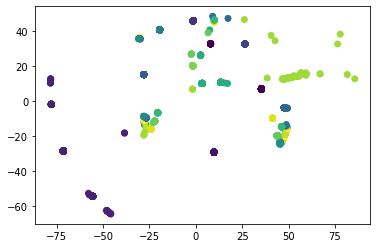

In [23]:
# Plotting the dbscan clusters (Fit pre-MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=data_2d_df['cluster'])

In [24]:
data_2d_df.iloc[:,:2]
kmeans = KMeans(n_clusters=16).fit(data_2d_df.iloc[:,:2])
print(silhouette_score(clusterVals, kmeans.labels_))
# Summarising how many observations belong to each cluster
kClusts = pd.DataFrame(kmeans.labels_, columns=["cluster"])
kClusts['cluster'].value_counts().sort_index()

0.857622086265996


0     1340
1      614
2      572
3      329
4      193
5      252
6      155
7       92
8      172
9      241
10     111
11      55
12     116
13     118
14       6
15      86
Name: cluster, dtype: int64

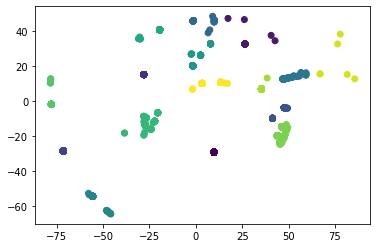

In [25]:
# k-means clustering (fit post-MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=kClusts['cluster'])

In [26]:
# Fitting the data with DBSCAN clustering
db_clust = DBSCAN(eps=0.01, min_samples=2).fit(data_2d_df.iloc[:,:2])
# Printing the cluster labels for each cluster
print(db_clust.labels_)
print(type(db_clust.labels_))
print(silhouette_score(data_2d_df.iloc[:,:2], db_clust.labels_))
dbClusts = pd.DataFrame(db_clust.labels_, columns=["cluster"])
dbClusts['cluster'].value_counts().sort_index()

[0 1 1 ... 1 1 1]
<class 'numpy.ndarray'>
0.91628938262963


0      275
1     1340
2      329
3      239
4      610
5      309
6       46
7      572
8      109
9       76
10       2
11     187
12     232
13       9
14      86
15       2
16      16
17       9
18       2
19       2
Name: cluster, dtype: int64

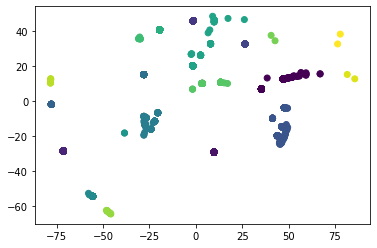

In [27]:
# DBSCAN Plot (fit post MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=dbClusts['cluster'])

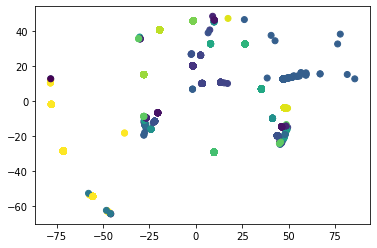

In [28]:
# HDBSCAN Plot (fit pre-MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=hdbClusts['cluster'])

In [29]:
# Scale the data down to 3 degrees
scaler = MDS(n_components=3,dissimilarity='precomputed')
data_3d = scaler.fit_transform(gow_dists)
data_3d.shape

(4452, 3)

In [30]:
# Make Data into a Dataframe
data_3d_df = pd.DataFrame(data=data_3d, columns = ['x','y','z'])
data_3d_df

,x,y,z
0,-0.031678,0.011906,0.031873
1,-0.013369,0.024479,-0.014154
2,-0.013368,0.024479,-0.014155
3,-0.002695,-0.052298,-0.054062
4,-0.037862,-0.018814,0.004885
...,...,...,...
4447,-0.013368,0.024479,-0.014155
4448,-0.013368,0.024479,-0.014155
4449,-0.013368,0.024479,-0.014155
4450,-0.013368,0.024479,-0.014155


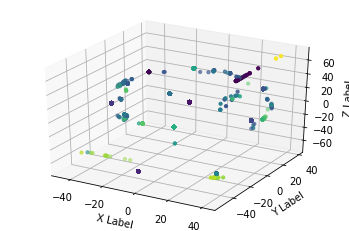

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scaleUp = 1000

x = data_3d_df['x']*scaleUp
y = data_3d_df['y']*scaleUp
z = data_3d_df['z']*scaleUp

ax.scatter(x, y, z, c=dbClusts['cluster'], s=10)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Clustering Methods Employing MDS to get a coordinate system
## Mixture Models
### Gaussian Mixture Model

In [64]:
num_clusts = 16
fit_data = data_3d
model = GaussianMixture(n_components=num_clusts).fit(fit_data)
preds = model.predict(fit_data)
print(silhouette_score(fit_data, preds))
print(model.bic(data_3d))
gmmClusts = pd.DataFrame(preds, columns=["cluster"])
gmmClusts['cluster'].value_counts().sort_index()

0.9391041754062261
-128420.3680058266


0       17
1     1340
2       93
3      342
4      171
5      610
6      572
7      232
8      134
9      137
10     165
11     263
12     139
13      74
14      91
15      72
Name: cluster, dtype: int64

In [78]:
num_clusts = 16
fit_data = data_3d
cov_type = ['full','tied','diag','spherical']
for cov in cov_type:
    model = GaussianMixture(n_components=num_clusts, covariance_type=cov,n_init=500).fit(fit_data)
    preds = model.predict(fit_data)
    print(cov)
    print("\t"+str(silhouette_score(fit_data, preds)))
    print("\t"+str(model.bic(data_3d)))

full
	0.9356788718736797
	-130582.8196306247
tied
	0.9375078128214454
	-105386.00091729756
diag
	0.931135309016291
	-130760.73282352286
spherical
	0.9151635943656546
	-131744.68651333792


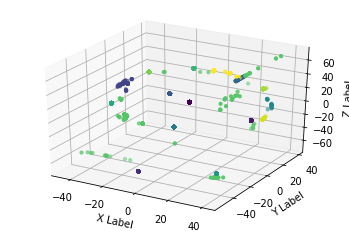

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scaleUp = 1000

x = data_3d_df['x']*scaleUp
y = data_3d_df['y']*scaleUp
z = data_3d_df['z']*scaleUp

ax.scatter(x, y, z, c=preds, s=10)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Variational Bayesian estimation of a Gaussian mixture

In [80]:
num_clusts = 16
fit_data = data_3d
cov_type = ['full','tied','diag','spherical']
for cov in cov_type:
    model = BayesianGaussianMixture(n_components=num_clusts, covariance_type=cov,n_init=10).fit(fit_data)
    preds = model.predict(fit_data)
    print(cov)
    print("\t"+str(silhouette_score(fit_data, preds)))

'''num_clusts = 16
fit_data = data_3d
model = BayesianGaussianMixture(n_components=num_clusts).fit(fit_data)
preds = model.predict(fit_data)
print(silhouette_score(fit_data, preds))
vbgmClusts = pd.DataFrame(preds, columns=["cluster"])
vbgmClusts['cluster'].value_counts().sort_index()'''

full
	0.928728172072301
tied
	0.9372017776843229
diag
	0.9337234368633113
spherical
	0.9320785506168126


'num_clusts = 16\nfit_data = data_3d\nmodel = BayesianGaussianMixture(n_components=num_clusts).fit(fit_data)\npreds = model.predict(fit_data)\nprint(silhouette_score(fit_data, preds))\nbgmClusts = pd.DataFrame(preds, columns=["cluster"])\nbgmClusts[\'cluster\'].value_counts().sort_index()'

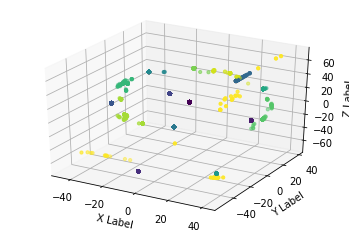

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scaleUp = 1000

x = data_3d_df['x']*scaleUp
y = data_3d_df['y']*scaleUp
z = data_3d_df['z']*scaleUp

ax.scatter(x, y, z, c=preds, s=10)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Mean Shift
Based on the below results probably not going to be useful for us

In [26]:
fit_data = data_3d
model = MeanShift(cluster_all=False).fit(fit_data)
preds = model.predict(fit_data)
print(silhouette_score(fit_data, preds))

msClusts = pd.DataFrame(preds, columns=["cluster"])
msClusts['cluster'].value_counts().sort_index()

0.5776542143579033


0    1595
1    1441
2     938
3     341
4     137
Name: cluster, dtype: int64

### Fuzzy C-means

In [29]:
import skfuzzy as fuzz

In [80]:
fit_data = data_3d
num_clusts = 16
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(np.transpose(fit_data), num_clusts, 4, error=0.005, maxiter=1000, init=None)
preds = np.argmax(u, axis=0)

print(silhouette_score(fit_data, preds))

fuzzClusts = pd.DataFrame(preds, columns=["cluster"])
fuzzClusts['cluster'].value_counts().sort_index()

0.9206130334137526


0      138
1      234
2       66
3      135
4      241
5      141
6       82
7     1340
8      341
9      164
10     572
11      49
12      78
13     164
14      97
15     610
Name: cluster, dtype: int64